Same as original script but with downsampling: eliminated all samples under 5000 reads and for all others, randomly sampled 5000 reads from the total reads

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn import preprocessing
import random
import seaborn as sns
import skbio.diversity.alpha as alpha
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [2]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T



(array([ 7.,  5.,  8., 10., 25., 48., 46., 75., 58., 75., 52., 64., 54.,
        40., 39., 46., 31., 36., 27., 27., 22., 27., 31., 21., 13., 17.,
        15.,  8.,  6., 11., 10.,  9.,  6.,  4.,  4.,  4.,  3.,  2.,  1.,
         3.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1665.  ,   4914.29,   8163.58,  11412.87,  14662.16,  17911.45,
         21160.74,  24410.03,  27659.32,  30908.61,  34157.9 ,  37407.19,
         40656.48,  43905.77,  47155.06,  50404.35,  53653.64,  56902.93,
         60152.22,  63401.51,  66650.8 ,  69900.09,  73149.38,  76398.67,
         79647.96,  82897.25,  86146.54,  89395.83,  92645.12,  95894.41,
         99143.7 , 102392.99, 105642.28, 108891.57, 112140.86, 1

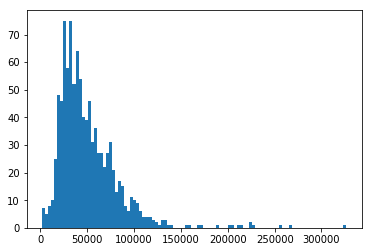

In [3]:
#Make histogram of reads per sample
plt.hist(otu_table.sum(axis=1),bins=100)

Choosing to downsample to 5000 reads based on this histogram

In [4]:
depth = 5000

In [5]:
#Eliminate samples with under 5000 reads
otu_table_downsampled = otu_table[otu_table.sum(axis=1) > depth]

In [6]:
#Convert remaining samples to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table_downsampled.div(otu_table_downsampled.sum(axis=1), axis=0)

In [10]:
#Randomly sample 5000 reads from each person in normalized table
prng = np.random.RandomState(0) #use seed 0
otu_table_np = otu_table_normalized.values
nvar = otu_table_np.shape[1]
print(nvar)

otu_table_np_rarefied = np.empty_like(otu_table_np)
p = np.zeros(otu_table_np.shape)

for i in range(otu_table_np.shape[0]):
    p[i] = otu_table_np[i]
    choice = prng.choice(nvar, depth, p=p[i])
    otu_table_np_rarefied[i] = np.bincount(choice, minlength=nvar)

46690


In [11]:
new_otu_table = pd.DataFrame(otu_table_np_rarefied, index=otu_table_downsampled.index, columns=otu_table_downsampled.columns)

In [12]:
#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
new_otu_table_normalized = new_otu_table.div(new_otu_table.sum(axis=1), axis=0)

In [13]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
new_otu_table_normalized = new_otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = new_otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = new_otu_table_normalized.iloc[0:int(midway)]
testing_table = new_otu_table_normalized.iloc[int(midway):]


1003


### Set conditions to test:

In [14]:
N = [5, 10, 25, 40, 50, 60, 75, 100, 200]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 30

### Functions

Returns list of weights to multiply by relative abundance matrix according to parameters n and weight

In [15]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]    

### Master loop: Generate all samples for given conditions

In [16]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = training_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                       0  \
OTU_ID                                     
sample_name                     5_even_0   
N                                      5   
weight_setup                        even   
weight_vector  [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed                        15956   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed                                                15956   

                                                               2  \
OTU_ID                                                             
sample_name                                       5_uneven_10x_0   
N         

In [17]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
new_final_matrix = final_matrix.T

In [18]:
#Save final_matrix to a csv file
new_final_matrix.to_csv('new_final_matrix.csv')

In [19]:
new_final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22219,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed
0,0,1.6e-05,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",15956
1,0,1.53846e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",15956
2,0,1.0989e-08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",15956
3,0,1.4652e-09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",15956
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2e-06,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",15412
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.83486e-08,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",15412
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9.65717e-10,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",15412
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.75585e-11,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",15412
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",12488
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",12488


### Look at various metrics from samples

#### Number of OTUs detected per sample

In [20]:
new_final_matrix['n_otus'] = new_final_matrix[:new_final_matrix.shape[0]-5].astype(bool).sum(axis=1).astype(int)

In [21]:
new_final_matrix_rel = new_final_matrix.iloc[:,:-6]
new_final_matrix_otus_only = new_final_matrix.iloc[:,:-6]*10000000
new_final_matrix_otus_only = new_final_matrix_otus_only.astype(int)

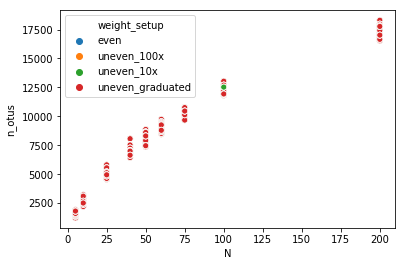

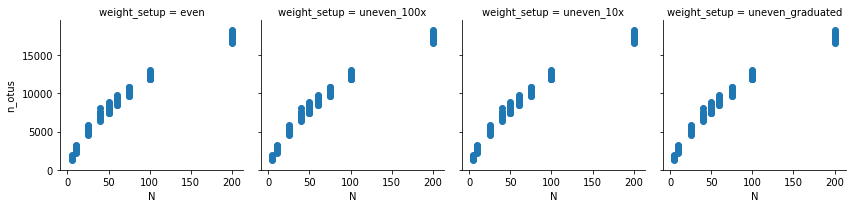

In [22]:
sns.scatterplot(x='N',y='n_otus',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'n_otus')
plt.show()

#### Alpha diversity: chao1

In [23]:
#final_matrix['chao1'] = [alpha.chao1(list(row),bias_corrected=True) for index, row in final_matrix_otus_only.iterrows()]

In [24]:
# sns.scatterplot(x='N',y='chao1',hue='weight_setup',data=final_matrix)
# plt.show()

# g = sns.FacetGrid(col='weight_setup', data=final_matrix)
# g.map(plt.scatter, 'N', 'chao1')
# plt.show()

#### Alpha diversity: fisher_alpha

In [25]:
#final_matrix['fisheralpha'] = [alpha.fisher_alpha(list(row)) for index, row in final_matrix_otus_only.iterrows()]

In [26]:
# sns.scatterplot(x='N',y='fisheralpha',hue='weight_setup',data=final_matrix)
# plt.show()

# g = sns.FacetGrid(col='weight_setup', data=final_matrix)
# g.map(plt.scatter, 'N', 'fisheralpha')
# plt.show()

#### Alpha diversity: shannon

Approach 1: Add 1 to every value in count matrix (converted from rel abundance matrix) and use skbio function

In [27]:
new_final_matrix['shannon_pseudocount'] = [alpha.shannon(list(row + 1),base=2) for index, row in new_final_matrix_otus_only.iterrows()]

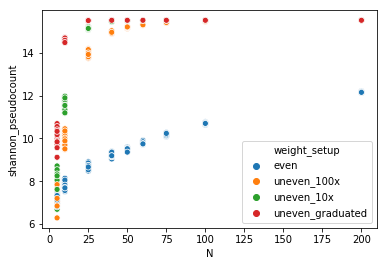

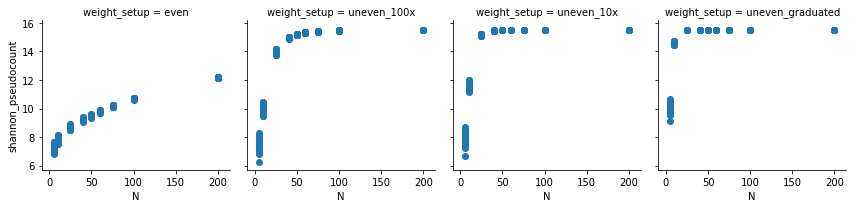

In [28]:
sns.scatterplot(x='N',y='shannon_pseudocount',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon_pseudocount')
plt.show()

Approach 2: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon using skbio function

In [29]:
min_value = new_final_matrix_rel[new_final_matrix_rel > 0].min().min()
print(min_value)
new_final_matrix_rel_add = new_final_matrix_rel + min_value
new_final_matrix['shannon'] = [alpha.shannon(list(row),base=2) for index, row in new_final_matrix_rel_add.iterrows()]


3.98067271935915e-18


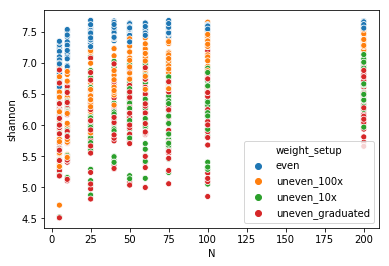

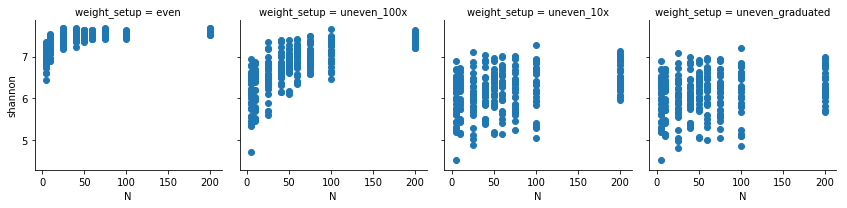

In [30]:
sns.scatterplot(x='N',y='shannon',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon')
plt.show()

Approach 3: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon by hand

In [31]:
new_final_matrix_shannon = new_final_matrix_rel_add.applymap(lambda x: x*math.log2(x))

In [32]:
new_final_matrix['shannon_by_hand'] = [-row.sum() for index, row in new_final_matrix_shannon.iterrows()]

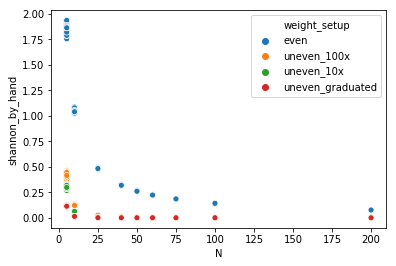

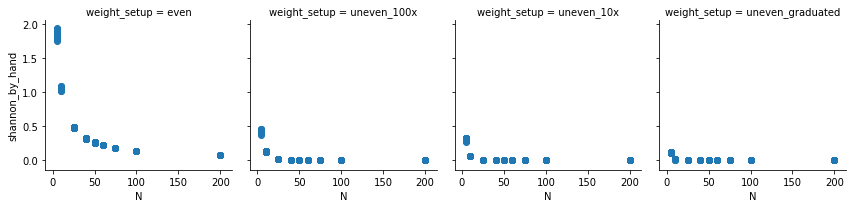

In [33]:
sns.scatterplot(x='N',y='shannon_by_hand',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand')
plt.show()

Approach 4: Take rel abundance matrix without adding minimum value, calculate shannon by hand

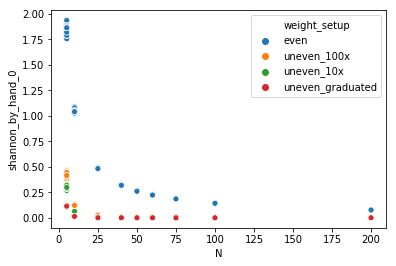

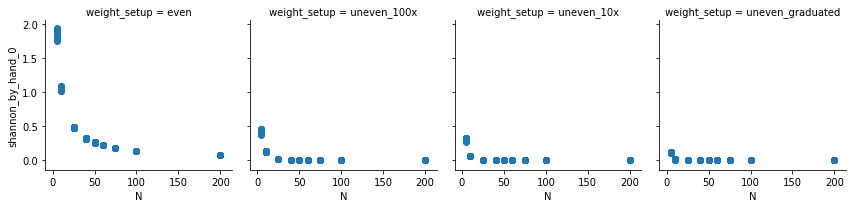

In [34]:
new_final_matrix_shannon = new_final_matrix_rel.applymap(lambda x: x*math.log2(x) if x!=0 else 0)
new_final_matrix['shannon_by_hand_0'] = [-row.sum() for index, row in new_final_matrix_shannon.iterrows()]

sns.scatterplot(x='N',y='shannon_by_hand_0',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand_0')
plt.show()

In [35]:
new_final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,sample_name,N,weight_setup,weight_vector,random_seed,n_otus,shannon_pseudocount,shannon,shannon_by_hand,shannon_by_hand_0
0,0,1.6e-05,0,0,0,0,0,0,0,0,...,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",15956,1822.0,7.425983,7.084778,1.881341e+00,1.881341e+00
1,0,1.53846e-07,0,0,0,0,0,0,0,0,...,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",15956,1822.0,7.522512,6.095184,4.295616e-01,4.295616e-01
2,0,1.0989e-08,0,0,0,0,0,0,0,0,...,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",15956,1822.0,7.948832,5.994880,3.082332e-01,3.082332e-01
3,0,1.4652e-09,0,0,0,0,0,0,0,0,...,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",15956,1822.0,10.095880,5.987176,1.170388e-01,1.170388e-01
4,0,0,0,0,0,0,0,0,0,0,...,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",15412,2533.0,7.759290,7.140096,1.046202e+00,1.046202e+00
5,0,0,0,0,0,0,0,0,0,0,...,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",15412,2533.0,9.995377,6.192705,1.283656e-01,1.283656e-01
6,0,0,0,0,0,0,0,0,0,0,...,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",15412,2533.0,11.612525,5.988256,6.659845e-02,6.659845e-02
7,0,0,0,0,0,0,0,0,0,0,...,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",15412,2533.0,14.601993,5.971837,1.421492e-02,1.421492e-02
8,0,0,0,0,0,0,0,0,0,0,...,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",12488,4994.0,8.504597,7.226564,4.748168e-01,4.748168e-01
9,0,0,0,0,0,0,0,0,0,0,...,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",12488,4994.0,13.973328,6.515519,2.528517e-02,2.528517e-02


### Random forest regression

First, tried training only on samples with even distribution

In [36]:
#Training only on samples with even distribution
X = new_final_matrix[new_final_matrix['weight_setup'] == 'even']
X_nolabels = X.iloc[:,:-10]
y = X['N']

In [37]:
regr = RandomForestRegressor(random_state=0)

In [38]:
regr = regr.fit(X_nolabels,y)

#### Generate test matrix

In [39]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = testing_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
test_matrix = pd.concat(df_list, axis=1)

In [40]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
new_test_matrix = test_matrix.T

#Save final_matrix to a csv file
new_test_matrix.to_csv('new_test_matrix.csv')

In [41]:
prediction = regr.predict(new_test_matrix.iloc[:,:-5])

In [42]:
new_test_matrix['prediction'] = prediction

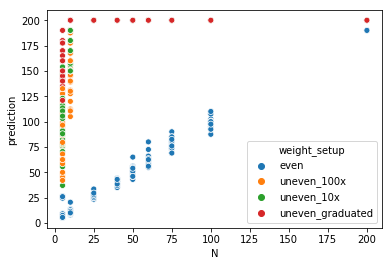

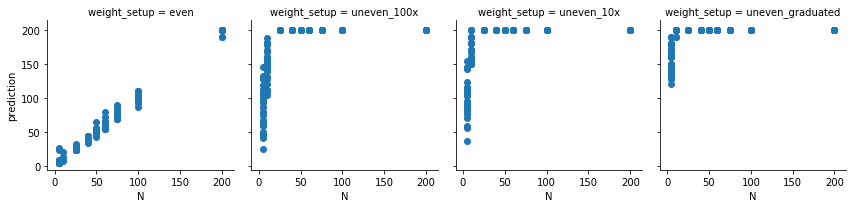

In [43]:
sns.scatterplot(x='N',y='prediction',hue='weight_setup', data=new_test_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_test_matrix)
g.map(plt.scatter, 'N', 'prediction')
plt.show()

In [44]:
new_test_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed,prediction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",20073,5.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",20073,77.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",20073,87.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",20073,146.0
4,0,2e-06,0,0,0,0,0,0,0,0,...,0,0,0,0,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",21529,11.0
5,0,1.83486e-08,0,0,0,0,0,0,0,0,...,0,0,0,0,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",21529,160.0
6,0,9.65717e-10,0,0,0,0,0,0,0,0,...,0,0,0,0,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",21529,180.0
7,0,7.0234e-11,0,0,0,0,0,0,0,0,...,0,0,0,0,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",21529,200.0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",11647,25.0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",11647,200.0


Now going to try training on all distributions and see if prediction improves

In [45]:
#Use entire training matrix for training
X2 = new_final_matrix
X2_nolabels = X2.iloc[:,:-10]
y2 = X2['N']

In [46]:
regr2 = RandomForestRegressor(random_state=0)
regr2 = regr.fit(X2_nolabels,y2)

In [47]:
prediction2 = regr2.predict(new_test_matrix.iloc[:,:-6])

In [48]:
new_test_matrix['prediction2'] = prediction2

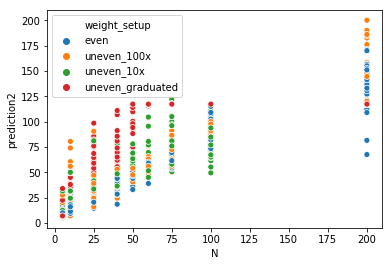

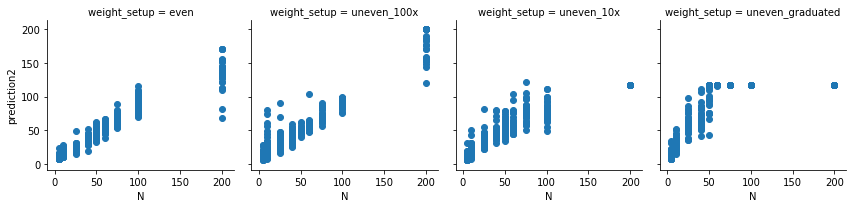

In [49]:
sns.scatterplot(x='N',y='prediction2',hue='weight_setup', data=new_test_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_test_matrix)
g.map(plt.scatter, 'N', 'prediction2')
plt.show()